RNN LSTM for text classification
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this notebook is to train recurrent neural network with LSTM cell for the purpose of text classification.

## 1. Data preparation

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from pathlib import Path
import os
import time

# custom libraries
from nlp.preparer import Corpus
from nlp.iterator import BatchIterator
from nlp.conveyor import Conveyor

# View
from IPython.display import Markdown, display

### Loading corpora

In [2]:
corpora_paths = ['./articles/good.articles', './articles/bad.articles'] 
corpora = []
lengths = []

for path in corpora_paths:
  corpus = Corpus(path, 321)
  corpora.append(corpus)
  length = [len(article) for article in corpus.articles]
  lengths.append(length)

  print(f"Corpus label: {corpus.label}, ",
        f"length: {len(corpus.articles)} articles, ",
        f"av length: {round(corpus.average_length())} words, ",
        f"max length: {max(length)} words.")
  print(f"Corpus raw article: {corpus.raw[0][:200]}")
  print(f"Corpus data (words): {corpus.articles[0][:20]}\n")

Corpus label: good,  length: 6617 articles,  av length: 207 words,  max length: 402 words.
Corpus raw article: 3 февраля в большинстве европейских стран закрылось зимнее трансферное окно — период, когда клубы могут заявлять новых футболистов, купленных у других команд. Ценники меняются чуть ли не ежемесячно. Н
Corpus data (words): ['num', 'феврал', 'в', 'большинств', 'европейск', 'стран', 'закр', 'зимн', 'трансферн', 'окн', 'период', ',', 'когд', 'клуб', 'могут', 'заявля', 'нов', 'футболист', ',', 'куплен']

Corpus label: bad,  length: 7518 articles,  av length: 84 words,  max length: 391 words.
Corpus raw article: Неизвестный угрожает взорвать аэропорт Кишинева, если ему не дадут миллион. Неизвестный сообщил о бомбе в аэропорту Международного аэропорта Кишинева и требует миллион рублей, сообщили в пограничной п
Corpus data (words): ['неизвестн', 'угрожа', 'взорва', 'аэропорт', 'кишинев', ',', 'есл', 'ем', 'не', 'дадут', 'миллион', '.', 'неизвестн', 'сообщ', 'о', 'бомб', 'в', 'аэропорт

### Visualizing articles lengths

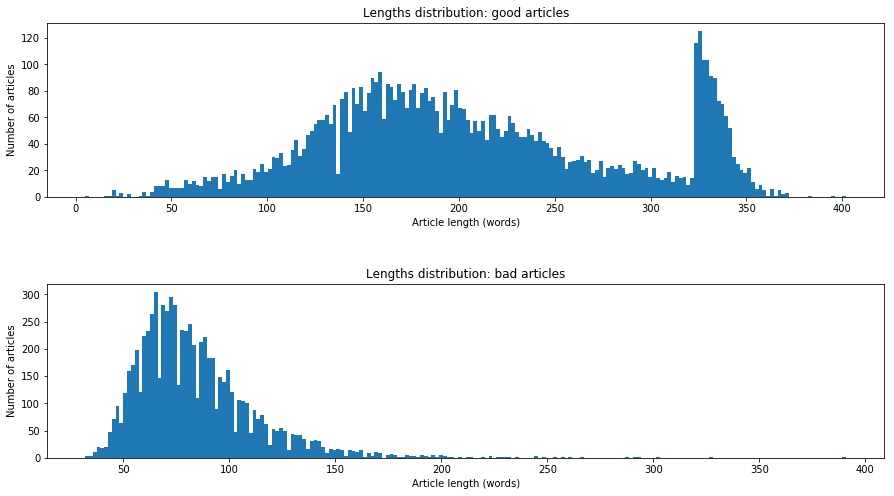

In [3]:
# visualization
plt.figure().set_size_inches(15, 8)

plt.subplot(211)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[0].label} articles')
plt.hist(lengths[0], 200)

plt.subplots_adjust(hspace=.5)

plt.subplot(212)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[1].label} articles')
plt.hist(lengths[1], 200)

plt.show()

### Building a dictionary

In [3]:
STORAGE_PATH = './storage/model' # to restore model's knowledge later
validation_size = 200 # articles per each class
vocabulary_size = 25000

def build_dictionary(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

  return dictionary, reverse_dictionary, count

def build_dataset(words, dictionary, count):
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  count[0][1] = count[0][1] + unk_count

  return data

# flatten all words into a single bag
all_words = [word for corpus in corpora for words in corpus.articles for word in words]

dictionary_file_name = f"{STORAGE_PATH}.dictionary"
if Path(dictionary_file_name).is_file():
  dictionary_file_size = os.path.getsize(dictionary_file_name)
  print(f"Loading dictionary from stored file ({dictionary_file_size} bytes)...")
  with open(dictionary_file_name, 'rb') as fp:
    dictionary, reverse_dictionary, count = pickle.load(fp)
else:
  print('Building dictionary from the corpora...')
  dictionary, reverse_dictionary, count = build_dictionary(all_words)
  print('Saving dictionary on disk for further access...')
  with open(dictionary_file_name, 'wb') as fp:
    pickle.dump((dictionary, reverse_dictionary, count), fp)
  dictionary_file_size = os.path.getsize(dictionary_file_name)
  print(f"Done. It took {dictionary_file_size} bytes on the disk.")

good_data = [build_dataset(article, dictionary, count) for article in corpora[0].articles]
bad_data  = [build_dataset(article, dictionary, count) for article in corpora[1].articles]

# shuffling
for data in [good_data, bad_data]: np.random.shuffle(data)

# Splitting between train and validation datasets
good_train_data = good_data[:-validation_size]
good_validation_data = good_data[-validation_size:]
bad_train_data = bad_data[:-validation_size]
bad_validation_data = bad_data[-validation_size:]
validation_data = [item for ga, ba in zip(good_validation_data, bad_validation_data) for item in [ga, ba]]

print(f"Top popular words counts: {count[:15]}\n")
print(f"Example word: {dictionary['слон']} => {reverse_dictionary[dictionary['слон']]}\n")
print(f'Example data: {good_data[0][:20]}\n')
print(f'Validation sizes split train / validation: {len(good_train_data)} / {len(good_validation_data)}')
print(f'Validation dataset size: {len(validation_data)}')

Loading dictionary from stored file (1194029 bytes)...
Top popular words counts: [['UNK', 30414], (',', 128485), ('.', 124529), ('в', 96291), ('num', 61427), ('и', 38544), ('на', 36182), ('с', 18901), ('по', 17567), ('что', 14996), ('эт', 13930), ('год', 12755), ('из', 12583), ('не', 11630), ('котор', 9868)]

Example word: 4071 => слон

Example data: [1180, 387, 108, 3049, 23, 206, 2, 17, 63, 486, 3780, 223, 16, 15, 1, 82, 6, 120, 206, 2]

Validation sizes split train / validation: 6417 / 200
Validation dataset size: 400


Below is an **example** of two training batches spat out by `BatchIterator`:

In [4]:
batch_size = 64 # Number of articles fed into a model at once
num_unrollings = 10 # Number of recurrent steps

good = [1., 0.] # Representation of first class
bad  = [0., 1.] # Representation of second class

min_size = min(len(good_train_data), len(bad_train_data))
articles_pool = [(data, good) for data in good_train_data[:min_size]] + \
                [(data, bad)  for data in bad_train_data[:min_size]]

conveyors = [Conveyor(articles_pool, num_unrollings) for _ in range(batch_size)]

for _ in range(2):
  bundle = conveyors[0].next()
  print(bundle)
  print([reverse_dictionary[index] for index in bundle[0]])
conveyors[0].rewind()

([195, 305, 3, 1892, 244, 1428, 125, 2, 305, 3], [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
['сми', 'ноч', 'в', 'луганск', 'произошел', 'мощн', 'взрыв', '.', 'ноч', 'в']
([1892, 244, 1428, 125, 2, 6, 261, 5470, 808, 233], [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
['луганск', 'произошел', 'мощн', 'взрыв', '.', 'на', 'улиц', 'слышн', 'сир', 'машин']


## 2. LSTM Model

In [5]:
num_nodes = 64 # Dimension of lstm cell
num_classes = 2 # Number of classes among which to predict
embedding_size = 128 # Dimension of a word vector
hidden_layer_size = 32

graph = tf.Graph()
with graph.as_default():

  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='ix')
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='im')
  ib = tf.Variable(tf.zeros([1, num_nodes]), name='ib')
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='fx')
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='fm')
  fb = tf.Variable(tf.zeros([1, num_nodes]), name='fb')
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='ox')
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='om')
  ob = tf.Variable(tf.zeros([1, num_nodes]), name='ob')
  # Memory cell: input, state and bias.
  cx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='cx')
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='cm')
  cb = tf.Variable(tf.zeros([1, num_nodes]), name='cb')
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, hidden_layer_size], -0.1, 0.1), name='w')
  b = tf.Variable(tf.zeros([hidden_layer_size]), name='b')
  hw = tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], -0.1, 0.1), name='hw')
  hb = tf.Variable(tf.zeros([num_classes]), name='hb')
  # Embeddings
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embeddings')


  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    # Create an LSTM cell
    input_gate =  tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)

    return output_gate * tf.tanh(state), state

  # Input data.
  train_inputs   = tf.placeholder(tf.int32,   shape=[batch_size, num_unrollings])
  train_clearers = tf.placeholder(tf.float32, shape=[batch_size, num_unrollings])
  train_labels   = tf.placeholder(tf.float32, shape=[batch_size, num_unrollings, num_classes])

  # Unrolled LSTM loop.
  lstm_outputs = list()
  output = saved_output
  state  = saved_state
  embedded_batch = tf.nn.embedding_lookup(embeddings, train_inputs)
  lstm_inputs = tf.unstack(embedded_batch, axis=1) # list of ~ (batch_size, embedding_size)
  lstm_state_clearers = tf.unstack(train_clearers, axis=1) # list of ~ (batch_size, )

  for lstm_input_batch, state_clearers_batch in zip(lstm_inputs, lstm_state_clearers):
    reshaped_clearers = tf.reshape(state_clearers_batch, (batch_size, 1))
    output, state = lstm_cell(lstm_input_batch,
                              tf.multiply(reshaped_clearers, output),
                              tf.multiply(reshaped_clearers, state))

    lstm_outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    # here we use `tf.reshape(tf.stack())` instead of `tf.concat` to preserve 0th and 1th axes order
    joined_output = tf.reshape(tf.stack(lstm_outputs, axis=1), (-1, num_nodes))   
    joined_labels = tf.reshape(train_labels, (-1, num_classes))

    hidden_layer = tf.nn.xw_plus_b(joined_output, w, b)
    activation = tf.nn.tanh(hidden_layer)
    logits = tf.nn.xw_plus_b(activation, hw, hb)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      labels=joined_labels,
      logits=logits
    ))

  # Optimizer.
  global_step = tf.Variable(0, trainable=False, name='global_step')
  learning_rate = tf.train.exponential_decay(4.0, global_step, 5000, 0.8, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)

  # Storing knowledge to the disk
  saver = tf.train.Saver()

  # Sampling and validation evaluation
  # ==================================
  #
  # Sampling eval: one unrolling, no state clearers
  sample_input = tf.placeholder(tf.int32, shape=[1])
  sample_lstm_input = tf.nn.embedding_lookup(embeddings, sample_input)
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_lstm_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    hidden_sample_pred = tf.nn.xw_plus_b(sample_output, w, b)
    sample_activation = tf.nn.tanh(hidden_sample_pred)
    sample_logits     = tf.nn.xw_plus_b(sample_activation, hw, hb)
    sample_prediction = tf.nn.softmax(sample_logits)

  valid_labels = tf.placeholder(tf.float32, shape=[None, num_classes])
  valid_logits = tf.placeholder(tf.float32, shape=[None, num_classes])  
  validation_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=valid_labels,
    logits=valid_logits
  ))

print('Graph was successfully built')

Graph was successfully built


## 3. Training

### Representation helpers

Before we dive into the very learning - let us define some useful helpers to better represent training process.

In [6]:
def print_md(string):
  display(Markdown(string))

def colored_p(text, prediction):
  g, r = [round(probability * 255) for probability in prediction]
  return f"<span style='color: rgb({r}, {g}, 0)'>{text}</span>"

def represent(words, predictions, tail=3):
  result = []
  temp = []
  changed_ago = 0
  for word, label, i in zip(words, predictions, range(len(words))):
    word_to_add = colored_p(word, label)

    if i == 0:
      temp.append(word_to_add)
      continue

    if label_to_color(predictions[i - 1]) == label_to_color(label):
      temp.append(word_to_add)
    else:
      if len(temp) > tail * 2:
        result += temp[:tail] + ['...'] + temp[-tail:]
      else:
        result += temp
      temp = [word_to_add]

  if len(temp) > tail * 2:
    result += temp[:tail] + ['...'] + temp[-tail:]
  else:
    result += temp

  overall_label = colored_p(f"=> {predictions[-1][0]:.2f}", predictions[-1])
  article = " ".join(result)

  return f"{overall_label} {article}"

def label_to_color(label):
  if abs(label[0] - label[1]) < 0.2: color = 'black'
  elif label[0] > label[1]:          color = 'green'
  else:                              color = 'red'

  return color

def colored(text, color='black'):
  colors = { 'black':'30',
             'red':'31',
             'green':'32',
             'yellow':'33',
             'blue':'34',
             'purple':'35',
             'sea-blue':'36' }

  return f"\x1b[{colors[color]}m{text}\x1b[0m"


def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

### Training process

In [7]:
num_steps = 7001
summary_frequency = 200
# validation_frequencies = [1000, 5000, 30000, 60000, 90000]

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()

  print('Initialized')
  mean_loss = 0
  losses   = []
  v_losses = []
  start_at = time.time()
  for step in range(num_steps):
    feed = ([], [], [])
    for conveyor in conveyors:
      bundle = conveyor.next()
      feed[0].append(bundle[0])
      feed[1].append(bundle[1])
      feed[2].append(bundle[2])

    feed_dict = { train_inputs: feed[0],
                  train_labels: feed[1],
                  train_clearers: feed[2] }

    _, l, lr = session.run(
      [optimizer, loss, learning_rate], feed_dict=feed_dict)
    mean_loss += l

    if step % summary_frequency == 0:
      if step > 0:
        # The mean loss is an estimate of the loss over the last few batches.
        mean_loss = mean_loss / summary_frequency

      # ======================================== Validation
      if step % (summary_frequency * 2) == 0:
        v_start_at = time.time()
        logits = []
        labels = []

        for i, article in enumerate(validation_data):
          reset_sample_state.run()
          current_label = good if i % 2 == 0 else bad
          for word in article:
            logits.append(sample_logits.eval({ sample_input: [word] })[0])
            labels.append(current_label)

        v_loss = validation_loss.eval({ valid_logits: logits, valid_labels: labels })
        v_losses.append(v_loss)
        v_taken = (time.time() - v_start_at)
        print(f"Validation loss: {v_loss:.4f}, taken: {v_taken:.2f} seconds")
      # ======================================== Validation

      print('Average loss at step %d: %.4f, learning rate: %.4f' % (step, mean_loss, lr))

      losses.append(mean_loss)
      mean_loss = 0

  taken = (time.time() - start_at) / 60
  print(f"Learning finished in {taken:.1f} minutes.")

  # save what have been learned
  saver.save(session, STORAGE_PATH)

Initialized
Validation loss: 0.7075, taken: 22.98 seconds
Average loss at step 0: 0.6884, learning rate: 4.0000
Average loss at step 200: 1.3995, learning rate: 4.0000
Validation loss: 0.5853, taken: 23.50 seconds
Average loss at step 400: 1.9295, learning rate: 4.0000
Average loss at step 600: 0.6441, learning rate: 4.0000
Validation loss: 0.2640, taken: 23.52 seconds
Average loss at step 800: 0.1415, learning rate: 4.0000
Average loss at step 1000: 0.1083, learning rate: 4.0000
Validation loss: 0.2188, taken: 23.46 seconds
Average loss at step 1200: 0.0993, learning rate: 4.0000
Average loss at step 1400: 0.0912, learning rate: 4.0000
Validation loss: 0.1917, taken: 22.95 seconds
Average loss at step 1600: 0.0836, learning rate: 4.0000
Average loss at step 1800: 0.0929, learning rate: 4.0000
Validation loss: 0.1471, taken: 22.95 seconds
Average loss at step 2000: 0.0670, learning rate: 4.0000
Average loss at step 2200: 0.0704, learning rate: 4.0000
Validation loss: 0.1188, taken: 23.

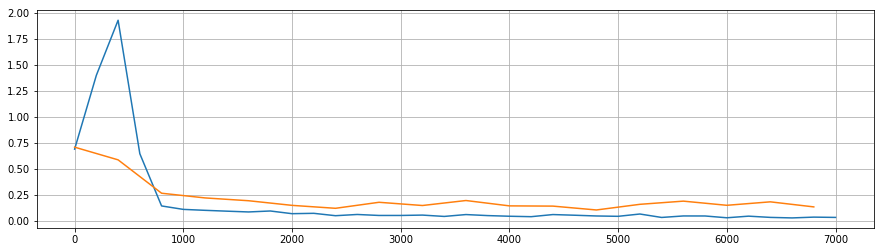

In [8]:
plt.figure().set_size_inches(15, 4)

x_axis  = [n * summary_frequency for n in range(0, len(losses))]
vx_axis = [n * summary_frequency * 2 for n in range(0, len(v_losses))]

plt.plot(x_axis, losses)
plt.plot(vx_axis, v_losses)
plt.grid()

plt.show()

## 4. Having fun

Let us now see the world with neural network's eyes.

First recollect what the model has learned:

In [9]:
def evaluate(articles, session):
  for article in articles:
    session.run(reset_sample_state)
    predicted = []
    for word in article:
      prediction = session.run(sample_prediction, { sample_input: [dictionary[word]] })
      predicted.append(prediction[0])

    print_md(represent(article, predicted))

Let's ask to evaluate some provoking statements:

In [10]:
with tf.Session(graph=graph) as session:
  saver.restore(session, STORAGE_PATH)

  articles = [['британск', 'совет', 'взорва', 'аэропорт', 'UNK', 'вечер', 'посл', 'испуг', 'вокруг'],
              ['британск', 'бомб', 'взорва', 'аэропорт', 'UNK', 'вечер', 'посл', 'испуг', 'вокруг'],
              ['бомб', 'взорва', 'аэропорт', 'UNK', 'вечер', 'посл', 'испуг', 'вокруг'],
              ['секс', 'бомб', 'взорва', 'аэропорт', 'UNK', 'вечер', 'посл', 'танц'],
              ['британск', 'секс', 'бомб', 'взорва', 'аэропорт', 'UNK', 'вечер', 'посл', 'испуг', 'вокруг']]

  evaluate(articles, session)

INFO:tensorflow:Restoring parameters from ./storage/model


<span style='color: rgb(0.0, 255.0, 0)'>=> 1.00</span> <span style='color: rgb(19.0, 236.0, 0)'>британск</span> <span style='color: rgb(1.0, 254.0, 0)'>совет</span> <span style='color: rgb(5.0, 250.0, 0)'>взорва</span> ... <span style='color: rgb(8.0, 247.0, 0)'>посл</span> <span style='color: rgb(12.0, 243.0, 0)'>испуг</span> <span style='color: rgb(0.0, 255.0, 0)'>вокруг</span>

<span style='color: rgb(93.0, 162.0, 0)'>=> 0.63</span> <span style='color: rgb(19.0, 236.0, 0)'>британск</span> <span style='color: rgb(136.0, 119.0, 0)'>бомб</span> <span style='color: rgb(248.0, 7.0, 0)'>взорва</span> <span style='color: rgb(251.0, 4.0, 0)'>аэропорт</span> <span style='color: rgb(235.0, 20.0, 0)'>UNK</span> <span style='color: rgb(158.0, 97.0, 0)'>вечер</span> <span style='color: rgb(245.0, 10.0, 0)'>посл</span> <span style='color: rgb(235.0, 20.0, 0)'>испуг</span> <span style='color: rgb(93.0, 162.0, 0)'>вокруг</span>

<span style='color: rgb(232.0, 23.0, 0)'>=> 0.09</span> <span style='color: rgb(235.0, 20.0, 0)'>бомб</span> <span style='color: rgb(254.0, 1.0, 0)'>взорва</span> <span style='color: rgb(254.0, 1.0, 0)'>аэропорт</span> ... <span style='color: rgb(254.0, 1.0, 0)'>посл</span> <span style='color: rgb(250.0, 5.0, 0)'>испуг</span> <span style='color: rgb(232.0, 23.0, 0)'>вокруг</span>

<span style='color: rgb(253.0, 2.0, 0)'>=> 0.01</span> <span style='color: rgb(51.0, 204.0, 0)'>секс</span> <span style='color: rgb(196.0, 59.0, 0)'>бомб</span> <span style='color: rgb(253.0, 2.0, 0)'>взорва</span> <span style='color: rgb(254.0, 1.0, 0)'>аэропорт</span> ... <span style='color: rgb(241.0, 14.0, 0)'>вечер</span> <span style='color: rgb(253.0, 2.0, 0)'>посл</span> <span style='color: rgb(253.0, 2.0, 0)'>танц</span>

<span style='color: rgb(6.0, 249.0, 0)'>=> 0.98</span> <span style='color: rgb(19.0, 236.0, 0)'>британск</span> <span style='color: rgb(3.0, 252.0, 0)'>секс</span> <span style='color: rgb(28.0, 227.0, 0)'>бомб</span> <span style='color: rgb(181.0, 74.0, 0)'>взорва</span> <span style='color: rgb(193.0, 62.0, 0)'>аэропорт</span> <span style='color: rgb(99.0, 156.0, 0)'>UNK</span> <span style='color: rgb(38.0, 217.0, 0)'>вечер</span> <span style='color: rgb(159.0, 96.0, 0)'>посл</span> <span style='color: rgb(144.0, 111.0, 0)'>испуг</span> <span style='color: rgb(6.0, 249.0, 0)'>вокруг</span>

As you can see, the results are quite impressive. The model does recognize the words by their context. Neural network here is at its best.

Moreover, prepending a statement with strongly provoking word `'неизвестный'` does not move the model off to a downward spiral of misunderstanding :)

In [11]:
with tf.Session(graph=graph) as session:
  saver.restore(session, STORAGE_PATH)

  articles = [['неизвестн', 'секс', 'бомб', 'раздел', 'в', 'аэропорт', 'UNK', '.', 'все', 'снима', 'вокруг'],
              ['неизвестн', 'бомб', 'раздел', 'в', 'аэропорт', 'UNK', '.', 'все', 'снима', 'вокруг'],
              ['неизвестн', 'секс', 'бомб', 'раздел', 'в', 'аэропорт'],
              ['неизвестн', 'секс', 'бомб', 'раздел', 'полност', 'в', 'аэропорт', 'для', 'фотосесс', 'вокруг'],
              ['неизвестн', 'сообщ', 'о', 'бомб', 'в', 'аэропорт', 'UNK', '.', 'все', 'испуга', 'вокруг'],
              ['неизвестн', 'сообщ', 'о', 'секс', 'бомб', 'в', 'аэропорт', 'UNK', '.', 'все', 'испуга', 'вокруг']]

  evaluate(articles, session)

INFO:tensorflow:Restoring parameters from ./storage/model


<span style='color: rgb(254.0, 1.0, 0)'>=> 0.00</span> <span style='color: rgb(253.0, 2.0, 0)'>неизвестн</span> <span style='color: rgb(243.0, 12.0, 0)'>секс</span> <span style='color: rgb(251.0, 4.0, 0)'>бомб</span> ... <span style='color: rgb(253.0, 2.0, 0)'>все</span> <span style='color: rgb(254.0, 1.0, 0)'>снима</span> <span style='color: rgb(254.0, 1.0, 0)'>вокруг</span>

<span style='color: rgb(255.0, 0.0, 0)'>=> 0.00</span> <span style='color: rgb(253.0, 2.0, 0)'>неизвестн</span> <span style='color: rgb(254.0, 1.0, 0)'>бомб</span> <span style='color: rgb(247.0, 8.0, 0)'>раздел</span> ... <span style='color: rgb(255.0, 0.0, 0)'>все</span> <span style='color: rgb(255.0, 0.0, 0)'>снима</span> <span style='color: rgb(255.0, 0.0, 0)'>вокруг</span>

<span style='color: rgb(253.0, 2.0, 0)'>=> 0.01</span> <span style='color: rgb(253.0, 2.0, 0)'>неизвестн</span> <span style='color: rgb(243.0, 12.0, 0)'>секс</span> <span style='color: rgb(251.0, 4.0, 0)'>бомб</span> <span style='color: rgb(210.0, 45.0, 0)'>раздел</span> <span style='color: rgb(247.0, 8.0, 0)'>в</span> <span style='color: rgb(253.0, 2.0, 0)'>аэропорт</span>

<span style='color: rgb(236.0, 19.0, 0)'>=> 0.07</span> <span style='color: rgb(253.0, 2.0, 0)'>неизвестн</span> <span style='color: rgb(243.0, 12.0, 0)'>секс</span> <span style='color: rgb(251.0, 4.0, 0)'>бомб</span> ... <span style='color: rgb(233.0, 22.0, 0)'>для</span> <span style='color: rgb(243.0, 12.0, 0)'>фотосесс</span> <span style='color: rgb(236.0, 19.0, 0)'>вокруг</span>

<span style='color: rgb(255.0, 0.0, 0)'>=> 0.00</span> <span style='color: rgb(253.0, 2.0, 0)'>неизвестн</span> <span style='color: rgb(255.0, 0.0, 0)'>сообщ</span> <span style='color: rgb(255.0, 0.0, 0)'>о</span> ... <span style='color: rgb(255.0, 0.0, 0)'>все</span> <span style='color: rgb(255.0, 0.0, 0)'>испуга</span> <span style='color: rgb(255.0, 0.0, 0)'>вокруг</span>

<span style='color: rgb(255.0, 0.0, 0)'>=> 0.00</span> <span style='color: rgb(253.0, 2.0, 0)'>неизвестн</span> <span style='color: rgb(255.0, 0.0, 0)'>сообщ</span> <span style='color: rgb(255.0, 0.0, 0)'>о</span> ... <span style='color: rgb(255.0, 0.0, 0)'>все</span> <span style='color: rgb(255.0, 0.0, 0)'>испуга</span> <span style='color: rgb(255.0, 0.0, 0)'>вокруг</span>

However, having someone notified of a sex-bomb in an airport is still considered a bad news. On the other hand - given the source of our _bad_ news - perhaps that is what we had taught our model to.